http://adventofcode.com/

# Day 1

In [2]:
def total(entries):
    return sum(int(l) for l in entries)

In [5]:
assert total(['+1', '-2', '+3', '+1']) == 3
assert total([+1, +1, +1]) == 3
assert total([+1, +1, -2]) == 0
assert total([-1, -2, -3]) == -6

In [31]:
def duplicate_result(entries, start=0, seen=None):
    if seen is None:
        seen = set([0])
    freq = start
    for item in entries:
        freq += int(item)
        if freq in seen:
            return freq
        seen.add(freq)
    return duplicate_result(entries, freq, seen)

In [34]:
assert duplicate_result([+1, -1]) == 0
assert duplicate_result([+3, +3, +4, -2, -4]) == 10
assert duplicate_result([-6, +3, +8, +5, -6]) == 5
assert duplicate_result([+7, +7, -2, -7, -4]) == 14

In [35]:
with open('input1.txt', 'rt') as f:
    nums = [int(i) for i in f]
    print('Part 1:', total(nums))
    print('Part 2:', duplicate_result(nums))

Part 1: 599
Part 2: 81204


# Day 2

In [36]:
from collections import Counter

def checksum(ids):
    twos = 0
    threes = 0
    for box in ids:
        counts = Counter(box)
        if 2 in counts.values():
            twos += 1
        if 3 in counts.values():
            threes += 1
    return twos * threes

In [37]:
assert checksum(['abcdef', 'bababc', 'abbcde', 'abcccd', 'aabcdd', 'abcdee', 'ababab']) == 12

In [75]:
import itertools

def find_boxes(ids):
    for box1, box2 in itertools.combinations(ids, 2):
        diff = [i==j for i,j in zip(box1, box2)]
        if sum(diff) == (len(box1) - 1):
            ind = diff.index(False)
            return box1[:ind] + box1[ind+1:]

In [76]:
assert find_boxes(['abcde', 'fghij', 'klmno', 'pqrst', 'fguij', 'axcye', 'wvxy']) == 'fgij'

In [77]:
with open('input2.txt', 'rt') as f:
    boxes = list(f)
    print('Part 1:', checksum(boxes))
    print('Part 2:', find_boxes(boxes))

Part 1: 7350
Part 2: wmlnjevbfodamyiqpucrhsukg



# Day 3

In [80]:
from collections import namedtuple
Claim = namedtuple('Claim', 'ident left top width height')

In [110]:
def parse(f):
    for line in f:
        claim_id, square = line.split('@')
        claim_id = int(claim_id[1:])
        loc, size = square.split(':')
        left, top = map(int, loc.split(','))
        width, height = map(int, size.split('x'))
        yield Claim(claim_id, left, top, width, height)

In [111]:
import numpy as np

def find_overlap_area(claims, size=1000):
    cloth = np.zeros((size, size))
    for claim in claims:
        cloth[claim.left:claim.left + claim.width, claim.top:claim.top + claim.height] += 1
    return (cloth > 1).sum()

In [112]:
claims = list(parse(['#1 @ 1,3: 4x4', '#2 @ 3,1: 4x4', '#3 @ 5,5: 2x2']))
assert find_overlap_area(claims) == 4

In [132]:
def find_nonoverlap(claims, size=1000):
    cloth = np.zeros((size, size), dtype=np.int)
    candidates = set()
    for claim in claims:
        area = cloth[claim.left:claim.left + claim.width, claim.top:claim.top + claim.height]
        if np.any(area):
            # Overlaps with some existing claims. Get them and remove all of them from the candidates
            for claim_id in np.unique(area):
                candidates -= {claim_id}
        else:
            # No overlap, so add to candidates
            candidates.add(claim.ident)
        # Regardless we need to mark off the area
        area[:] = claim.ident
    return list(candidates)[0]

In [133]:
assert find_nonoverlap(claims) == 3

In [134]:
with open('input3.txt', 'rt') as f:
    claims = list(parse(f))
    print('Part 1:', find_overlap_area(claims))
    print('Part 2:', find_nonoverlap(claims))

Part 1: 97218
Part 2: 717


# Day 4

In [175]:
from collections import defaultdict
from datetime import datetime

def parse(f):
    cur_guard = 0
    sleep = 0
    log = defaultdict(list)
    for line in sorted(f):
        dt, action = line.split(']')
        action = action.strip()
        dt = datetime.strptime(dt, '[%Y-%m-%d %H:%M')
        if action.startswith('Guard'):
            cur_guard = int(action.split('#', maxsplit=1)[1].split()[0])
        elif 'asleep' in action:
            sleep = dt.minute
        elif 'wakes' in action:
            log[cur_guard].append((sleep, dt.minute))
    return log

In [180]:
import numpy as np

def strategy1(log):
    max_guard = 0
    max_total = 0
    max_minute = 0
    for guard, times in log.items():
        sleeping = np.zeros((60,), dtype=np.int)
        for start, end in times:
            sleeping[start:end] += 1
        total = sleeping.sum()
        if total > max_total:
            max_total = total
            max_guard = guard
            max_minute = sleeping.argmax()
    return max_guard * max_minute

In [184]:
def strategy2(log):
    guards = np.zeros((60,), dtype=np.int)
    total_sleep = np.zeros((60,), dtype=np.int)
    for guard, times in log.items():
        sleeping = np.zeros((60,), dtype=np.int)
        for start, end in times:
            sleeping[start:end] += 1
        more_asleep = sleeping > total_sleep
        guards[more_asleep] = guard
        total_sleep[more_asleep] = sleeping[more_asleep]
    best_time = total_sleep.argmax()
    return guards[best_time] * best_time

In [185]:
from io import StringIO
testdata = StringIO('''[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up''')
log = parse(testdata)

In [186]:
assert strategy1(log) == 240

In [187]:
assert strategy2(log) == 4455

In [188]:
with open('input4.txt', 'rt') as f:
    log = parse(f)
    print('Part 1:', strategy1(log))
    print('Part 2:', strategy2(log))

Part 1: 109659
Part 2: 36371


# Day 5

In [1]:
def collapse(s):
    changed = True
    s = [ord(c) for c in s]
    while changed:
        pointer = 0
        new_s = []
        changed = False
        while pointer < len(s) - 1:
            # Are these collapsing?
            if abs(s[pointer] - s[pointer + 1]) == 32:
                # Skip past the one we just annihilated
                pointer += 1
                changed = True
            else:
                new_s.append(s[pointer])

            # Move to the next check location    
            pointer += 1

        # Add the last item if we didn't blow it away
        if pointer < len(s):
            new_s.append(s[pointer])
        s = new_s
    return len(s)

In [2]:
assert collapse('aA') == 0
assert collapse('abBA') == 0
assert collapse('abAB') == 4
assert collapse('aabAAB') == 6
assert collapse('dabAcCaCBAcCcaDA') == 10

In [3]:
import string

with open('input5.txt', 'rt') as f:
    polymer = f.read().rstrip()
    print('Part 1:', collapse(polymer))
    print('Part 2:', min(collapse(polymer.replace(c, '').replace(c.lower(), ''))
                         for c in string.ascii_uppercase))

Part 1: 11252
Part 2: 6118


# Day 6

In [35]:
import numpy as np

def coverage(locs):
    nearest = np.zeros((1000, 1000), dtype=np.int)
    best_dist = np.full_like(nearest, np.inf, dtype=np.float64)
    ygrid = np.arange(nearest.shape[0])[:, None]
    xgrid = np.arange(nearest.shape[1])
    for ind, (x, y) in enumerate(locs):
        dist = np.abs(x - xgrid) + np.abs(y - ygrid)
        even = dist == best_dist
        nearest[even] = -1
        better = dist < best_dist
        best_dist[better] = dist[better]
        nearest[better] = ind
    
    candidates = set(range(len(locs)))
    candidates -= set(nearest[:, 0])
    candidates -= set(nearest[:, -1])
    candidates -= set(nearest[0, :])
    candidates -= set(nearest[-1, :])
    
    return max((nearest == c).sum() for c in candidates)

In [36]:
assert coverage([(1, 1), (1, 6), (8, 3), (3, 4), (5, 5), (8, 9)]) == 17

In [49]:
def region_max_total_dist(locs, thresh=10000):
    size = 1000
    total_dist = np.zeros((size, size), dtype=np.int)
    ygrid = np.arange(total_dist.shape[0])[:, None]
    xgrid = np.arange(total_dist.shape[1])
    for ind, (x, y) in enumerate(locs):
        dist = np.abs(x - xgrid) + np.abs(y - ygrid)
        total_dist += dist
        
#    print(total_dist < thresh)
    return (total_dist < thresh).sum()

In [50]:
assert region_max_total_dist([(1, 1), (1, 6), (8, 3), (3, 4), (5, 5), (8, 9)], 32) == 16

In [52]:
with open('input6.txt', 'rt') as f:
    locs = [tuple(map(int, l.split(','))) for l in f]
    print('Part 1:', coverage(locs))
    print('Part 2:', region_max_total_dist(locs))

Part 1: 4233
Part 2: 45290


# Day 7

In [103]:
from collections import defaultdict

def parse(f):
    graph = defaultdict(list)
    deps = defaultdict(list)
    for line in f:
        parts = line.split()
        start = parts[1]
        end = parts[7]
        graph[start].append(end)
        graph[end] # Need to make sure graph has end nodes as well
        deps[end].append(start)
        deps[start]
    return graph, deps

In [104]:
def topo_sort(graph):
    order = []
    seen = set()
    for node in sorted(graph)[::-1]:
        visit(graph, node, order, seen)
    return order

def visit(graph, node, order, seen):
    if node in seen:
        return

    for n in sorted(graph[node])[::-1]:
        visit(graph, n, order, seen)

    seen.add(node)
    order.insert(0, node)

In [190]:
import heapq

def process_queue(graph, deps, num_workers=5, extra=60):
    done = set()
    total_time = 0
    avail = [i for i in topo_sort(graph) if not deps[i]]

    workers = []
    tasks = deps.copy()
    while tasks or workers:
#         print('top:', tasks, workers)
        # Do we have work available and capacity
        while len(workers) < num_workers and avail:
            task = avail.pop(0)
            if task in tasks:
                heapq.heappush(workers, (total_time + extra + ord(task) - ord('A') + 1, task))
#                 print('Added worker:', total_time, (total_time + extra + ord(task) - ord('A') + 1, task))
                tasks.pop(task)

        # Need to advance the loop by peeking at the next done worker
        total_time = workers[0][0]

        # Clean up everyone that's done
        while workers and workers[0][0] == total_time:
            _, task = heapq.heappop(workers)
            done.add(task)
            for item in graph[task]:
                if not set(deps[item]) - done:
#                      print('Item available:', item)
                     avail = sorted(set(avail) | set(item)) 

    return total_time

In [191]:
from io import StringIO
testdata = StringIO('''Step C must be finished before step A can begin.
Step C must be finished before step F can begin.
Step A must be finished before step B can begin.
Step A must be finished before step D can begin.
Step B must be finished before step E can begin.
Step D must be finished before step E can begin.
Step F must be finished before step E can begin.''')
graph, deps = parse(testdata)

In [192]:
assert topo_sort(graph) == list('CABDFE')

In [193]:
assert process_queue(graph, deps, 2, 0) == 15

In [194]:
with open('input7.txt', 'rt') as f:
    graph, deps = parse(f)
    print('Part 1:', ''.join(topo_sort(graph)))
    print('Part 2:', process_queue(graph, deps))

Part 1: ABDCJLFMNVQWHIRKTEUXOZSYPG
Part 2: 896


# Day 8

In [206]:
def process(s):
    return list(map(int, s.split()))

In [207]:
vals = process('2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2')

In [208]:
def handle_tree(vals):
    num_children = next(vals)
    num_metadata = next(vals)
    total = 0
    for _ in range(num_children):
        total += handle_tree(vals)
    for _ in range(num_metadata):
        total += next(vals)
    return total
    

In [210]:
assert handle_tree(iter(vals)) == 138

In [211]:
def handle_tree2(vals):
    num_children = next(vals)
    num_metadata = next(vals)
    children = [handle_tree2(vals) for _ in range(num_children)]
    metadata = [next(vals) for _ in range(num_metadata)]
    if not children:
        return sum(metadata)
    else:
        return sum(children[i - 1] for i in metadata if 1<=i<=len(children))
    

In [212]:
assert handle_tree2(iter(vals)) == 66

In [214]:
with open('input8.txt', 'rt') as f:
    vals = process(f.read())
    print('Part 1:', handle_tree(iter(vals)))
    print('Part 2:', handle_tree2(iter(vals)))

Part 1: 37262
Part 2: 20839


# Day 9

In [260]:
def marbles(p, n):
    circle = [0]
    scores = [0] * p
    cur_ind = 0
    for m in range(1, n + 1):
        if m % 23:
            cur_ind = (cur_ind + 1) % len(circle) + 1
            circle.insert(cur_ind, m)
        else:
            cur_ind = (cur_ind - 7) % len(circle)
            scores[m % p - 1] += m + circle.pop(cur_ind)
#        print(circle)
#    print(scores)
    return max(scores)

In [268]:
assert marbles(9, 25) == 32
assert marbles(10, 1618) == 8317
assert marbles(13, 7999) == 146373
assert marbles(17, 1104) == 2764
assert marbles(21, 6111) == 54718
assert marbles(30, 5807) == 37305

In [271]:
marbles(411, 72059)

429943

In [270]:
marbles(411, 7205900)

3615691746

# Day 10

In [22]:
def parse(f):
    for line in f:
        _, coords = line[:25].split('=')
        x = int(coords[1:7])
        y = int(coords[8:15])
        _, comps = line[25:].split('=')
        u = int(comps[1:3])
        v = int(comps[4:7])
        yield x, y, u, v

In [79]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams['animation.html'] = 'jshtml'

def anim(vals):
    x, y, u, v = vals.T
    
    fig, ax = plt.subplots()
    line, = ax.plot(x, y, linestyle='none', marker='x')
    ax.set_xlim(180, 270)
    ax.set_ylim(200, 150)
    
    def frame(i):
        time = 10639 + i * 1
        cur_x = x + time * u
        cur_y = y + time * v
        line.set_data(cur_x, cur_y)
        ax.set_title('Time: {}'.format(time))
        ax.autoscale_view()
        return ax
    
    anim = FuncAnimation(fig, frame, frames=10)
    display(anim)

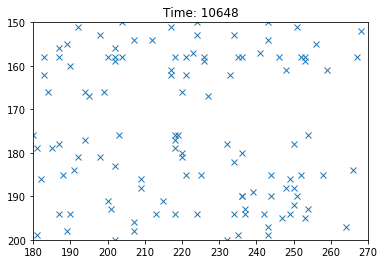

In [80]:
import numpy as np
with open('input10.txt', 'rt') as f:
    vals = np.array(list(parse(f)))
    anim(vals)

# Day 11

In [297]:
import numpy as np

my_id = 9798

def get_level(x, y, serial=my_id):
    rack = x + 10
    return ((rack * y + serial) * rack % 1000) // 100 - 5

def gen_grid(nx, ny, serial=my_id):
    x = np.arange(1, nx + 1)
    y = np.arange(1, ny + 1)[:, None]
    return get_level(x, y, serial)

#def find_

In [298]:
assert get_level(3, 5, 8) == 4
assert get_level(122, 79, 57) == -5
assert get_level(217, 196, 39) == 0
assert get_level(101, 153, 71) == 4

In [327]:
def find_max(grid, size=3):
    max_loc = (0, 0)
    max_sum = -2**32
    for i in range(grid.shape[0] - size + 1):
        for j in range(grid.shape[1] - size + 1):
            total = np.sum(grid[i:i+size, j:j+size])
            if total > max_sum:
                max_sum = total
                max_loc = (j + 1, i + 1)
    return max_loc, max_sum

def find_max_box(grid, cap=30):
    max_loc = (0, 0)
    max_sum = -2**32
    max_size = 0
    for size in range(1, cap):
        loc, total = find_max(grid, size)
        if total > max_sum:
            max_loc = loc
            max_size = size
            max_sum = total
    return max_loc, max_size, max_sum

In [328]:
assert find_max(gen_grid(300, 300, 18))[0] == (33, 45)
assert find_max(gen_grid(300, 300, 42))[0] == (21, 61)

In [329]:
find_max_box(gen_grid(300, 300, 18))

((90, 269), 16, 113)

In [331]:
find_max(gen_grid(300, 300, 9798))

((44, 37), 29)

In [332]:
find_max_box(gen_grid(300, 300, 9798))

((235, 87), 13, 121)

# Day 12

In [84]:
def parse(f):
    init = f.readline().split(':')[1].strip()
    f.readline()
    rules = dict()
    for line in f:
        pattern, res = line.strip().split(' => ')
        if res == '#':
            rules[pattern] = res
    return init, rules

In [85]:
from io import StringIO
f = StringIO('''initial state: #..#.#..##......###...###

...## => #
..#.. => #
.#... => #
.#.#. => #
.#.## => #
.##.. => #
.#### => #
#.#.# => #
#.### => #
##.#. => #
##.## => #
###.. => #
###.# => #
####. => #''')

In [86]:
init, rules = parse(f)

In [87]:
def follow_rules(init, rules, generations=20):
    prepended = appended = 0
    buf = init
    #print(buf)
    for _ in range(generations):
        parts = []
        if '....' + buf[0] in rules:
            prepended += 1
            parts.append('#')
        if '...' + buf[:2] in rules:
            prepended += 1
            parts.append('#')
        for i in range(len(buf)):
            if i < 2:
                group = (2 - i) * '.' + buf[:i+3]
            elif i >= len(buf) - 2:
                group = buf[i-2:] + ('..' if i == len(buf) - 1 else '.')
            else:
                group = buf[i-2:i+3]

            parts.append(rules.get(group, '.'))
    #        print(group, '=>', parts[-1])
        if buf[-2:] + '...' in rules:
            appended += 1
            parts.append('#')
        if buf[-1] + '....' in rules:
            appended += 1
            parts.append('#')
        buf = ''.join(parts)
    #    print(buf)    
    return prepended, buf

In [88]:
def score(line, prepended):
    return sum(i for i,m in zip(range(-prepended, len(line)), line) if m=='#')

In [89]:
pre, line = follow_rules(init, rules)
assert score(line, pre) == 325

In [93]:
with open('input12.txt', 'rt') as f:
    init, rules = parse(f)
    pre, line = follow_rules(init, rules)
    print('Part 1:', score(line, pre))
    pre, line = follow_rules(init, rules, 1000)
    print('Part 2:', score(line, pre))

Part 1: 3421
Part 2: 52195


In [99]:
for i in range(5):
    pre, line = follow_rules(init, rules, 1000 * (i + 1))
    print(score(line, pre))

52195
103195
154195
205195
256195


In [101]:
51000 * (50000000 - 1) + 52195

2550000001195

# Day 13

In [168]:
class Cart:
    directions = {'v': (0, 1), '^': (0, -1), '<': (-1, 0), '>': (1, 0)}
    def __init__(self, x, y, direction):
        self.x = x
        self.y = y
        self.dx, self.dy = self.directions[direction]
        self.nextturn = 0
    
    def move(self, network):
        self.x += self.dx
        self.y += self.dy
        path = network[self.y][self.x]
        if path in ('/', '\\'):
            self.turn(path)
        elif path == '+':
            self.handle_intersection()

    def handle_intersection(self):
        if self.nextturn == 0: # Left
            self.dx, self.dy = self.dy, -self.dx
        elif self.nextturn == 2: # Right
            self.dx, self.dy = -self.dy, self.dx
        # Otherwise go straight

        self.nextturn = (self.nextturn + 1) % 3

    def turn(self, path):
        if path == '/':
            self.dx, self.dy = -self.dy, -self.dx
        elif path == '\\':
            self.dx, self.dy = self.dy, self.dx

    def __lt__(self, other):
        return (self.y, self.x) < (other.y, other.x)
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __str__(self):
        return ('X: {0.x:3d} Y: {0.y:3d} dx: {0.dx:2d} dy: {0.dy:2d}'.format(self))
    
    __repr__ = __str__


def run(network, carts):
    tick = 0
    while True:
        tick += 1
        todo = sorted(carts)[::-1]
        done = set()
#         print(tick)
        while todo:
            cart = todo.pop()
#             print(cart)
            cart.move(network)
            if cart in (set(todo)|done):
                print(tick)
                return cart.x, cart.y
            done.add(cart)

def crash_all(network, carts):
    tick = 0
    done = carts
    while len(done) > 1:
        tick += 1
        todo = sorted(done)[::-1]
        done = set()
#         print(tick)
        while todo:
            cart = todo.pop()
            #print(cart)
            cart.move(network)
            if cart in (set(todo) | done):
                print('Crashed:', cart)
                if cart in done:
                    done.remove(cart)
                if cart in todo:
                    todo.remove(cart)
            else:
                done.add(cart)
#         print(len(done))
    return list(done)[0].x, list(done)[0].y

In [169]:
def parse(f):
    carts = []
    network = list(f)
    for y, row in enumerate(network):
        for x, path in enumerate(row):
            if path in Cart.directions:
                carts.append(Cart(x, y, path))
    return network, carts

In [170]:
from io import StringIO
f = StringIO(r'''/->-\        
|   |  /----\
| /-+--+-\  |
| | |  | v  |
\-+-/  \-+--/
  \------/   
''')
network, carts = parse(f)

In [171]:
crash = run(network, carts)
assert crash == (7, 3)

14


In [172]:
f2 = StringIO(r'''/>-<\  
|   |  
| /<+-\
| | | v
\>+</ |
  |   ^
  \<->/
''')
network, carts = parse(f2)
assert crash_all(network, carts) == (6, 4)

Crashed: X:   2 Y:   0 dx: -1 dy:  0
Crashed: X:   2 Y:   4 dx:  0 dy:  1
Crashed: X:   6 Y:   4 dx:  0 dy: -1
Crashed: X:   2 Y:   4 dx: -1 dy:  0


In [173]:
with open('input13.txt', 'rt') as f:
    network, carts = parse(f)
    crash = run(network, carts)
    print('Part 1:', crash)
with open('input13.txt', 'rt') as f:
    network, carts = parse(f)
    print('Part 2:', crash_all(network, carts))

197
Part 1: (14, 42)
Crashed: X:  14 Y:  42 dx:  1 dy:  0
Crashed: X:  88 Y:  48 dx:  1 dy:  0
Crashed: X:  47 Y:  12 dx:  1 dy:  0
Crashed: X: 110 Y:  76 dx:  1 dy:  0
Crashed: X:  12 Y:  45 dx:  0 dy:  1
Crashed: X:  88 Y:  84 dx:  0 dy:  1
Crashed: X: 122 Y:  42 dx:  0 dy:  1
Crashed: X: 146 Y:  95 dx:  0 dy: -1
Part 2: (8, 7)


# Day 14

In [179]:
def get_recipes(n, s=None):
    if s is None:
        s = [3, 7]
    i = 0
    j = 1
    while len(s) < n + 10:
        next_recipe = s[i] + s[j]
        if next_recipe >= 10:
            s.extend(divmod(next_recipe, 10))
        else:
            s.append(next_recipe)
        i = (i + 1 + s[i]) % len(s)
        j = (j + 1 + s[j]) % len(s)
    return ''.join(str(v) for v in s[n:n+10])

In [183]:
assert get_recipes(9) == '5158916779'
assert get_recipes(5) == '0124515891'
assert get_recipes(18) == '9251071085'
assert get_recipes(2018) == '5941429882'

In [210]:
def find_recipe(needle, s=None):
    if s is None:
        s = '37'
    i = 0
    j = 1
    while s.find(needle, -len(needle) - 2) == -1:
        si = int(s[i])
        sj = int(s[j])
        next_recipe = si + sj
        s += str(next_recipe)
        i = (i + 1 + si) % len(s)
        j = (j + 1 + sj) % len(s)
    return s.find(needle)

In [211]:
assert find_recipe('51589') == 9
assert find_recipe('01245') == 5
assert find_recipe('92510') == 18
assert find_recipe('59414') == 2018

In [212]:
print('Part 1:', get_recipes(793061))
print('Part 2:', find_recipe('793061'))

Part 1: 4138145721
Part 2: 20276284


# Day 15

In [424]:
class Actor:
    def __init__(self, grid, x, y):
        self.grid = grid
        self.x = x
        self.y = y

    def __str__(self):
        return '{0}({1.x}, {1.y})'.format(type(self).__name__, self)

    @staticmethod
    def fromcode(code, grid, x, y):
        if code == 'E':
            return Elf(grid, x, y)
        elif code == 'G':
            return Goblin(grid, x, y)

    def go(self):
        pass
    
    def move(self):
        pass

    @property
    def reachable(self):
        todo = [(self.x + 1, self.y), (self.x - 1, self.y), (self.x, self.y + 1), (self.x, self.y - 1)]
        visited = set()
        while todo:
            pt = todo.pop()
            if pt in visited:
                continue
            visited.add(pt)
            x, y = pt
            if self.grid[y][x] == '.':
                todo.extend([(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)])
                yield pt


    __repr__ = __str__


class Goblin(Actor):
    pass


class Elf(Actor):
    pass

In [425]:
def parse(f):
    grid = [list(line.rstrip()) for line in f]

    actors = []
    for y, row in enumerate(grid):
        for x, block in enumerate(row):
            if block in ('E', 'G'):
                actors.append(Actor.fromcode(block, grid, x, y))

    return actors, grid

In [426]:
from io import StringIO
f = StringIO('''#######
#E..G.#
#...#.#
#.G.#G#
#######''')

In [427]:
actors, grid = parse(f)

In [428]:
actors

[Elf(1, 1), Goblin(4, 1), Goblin(2, 3), Goblin(5, 3)]

In [429]:
set(actors[0].reachable)

{(1, 2), (1, 3), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)}

# Day 16

In [297]:
class Computer:
    def __init__(self, regs=None):
        if regs is None:
            regs = [0, 0, 0, 0]
        self.regs = regs

    def addr(self, a, b, c):
        self.regs[c] = self.regs[a] + self.regs[b]

    def addi(self, a, b, c):
        self.regs[c] = self.regs[a] + b

    def mulr(self, a, b, c):
        self.regs[c] = self.regs[a] * self.regs[b]

    def muli(self, a, b, c):
        self.regs[c] = self.regs[a] * b

    def banr(self, a, b, c):
        self.regs[c] = self.regs[a] & self.regs[b]

    def bani(self, a, b, c):
        self.regs[c] = self.regs[a] & b

    def borr(self, a, b, c):
        self.regs[c] = self.regs[a] | self.regs[b]

    def bori(self, a, b, c):
        self.regs[c] = self.regs[a] | b

    def setr(self, a, b, c):
        self.regs[c] = self.regs[a]

    def seti(self, a, b, c):
        self.regs[c] = a

    def gtir(self, a, b, c):
        self.regs[c] = int(a > self.regs[b])

    def gtri(self, a, b, c):
        self.regs[c] = int(self.regs[a] > b)

    def gtrr(self, a, b, c):
        self.regs[c] = int(self.regs[a] > self.regs[b])

    def eqir(self, a, b, c):
        self.regs[c] = int(a == self.regs[b])

    def eqri(self, a, b, c):
        self.regs[c] = int(self.regs[a] == b)

    def eqrr(self, a, b, c):
        self.regs[c] = int(self.regs[a] == self.regs[b])

    def train(self, commands, before, after):
        all_funcs = (self.addr, self.addi, self.mulr, self.muli,
                     self.banr, self.bani, self.borr, self.bori,
                     self.setr, self.seti, self.gtir, self.gtri,
                     self.gtrr, self.eqir, self.eqri, self.eqrr)
        opcode_map = dict()
        for b, c, a in zip(before, commands, after):
            opcode, *params = c
            options = opcode_map.setdefault(opcode, list(all_funcs))
            works = []
            for cmd in options:
                self.regs = b.copy()
                cmd(*params)
                if self.regs == a:
                    works.append(cmd)
            opcode_map[opcode] = works

        # Determine what options exist for each funciton rather than each code
        func_options = dict()
        for code, options in opcode_map.items():
            for o in options:
                func_options.setdefault(o, []).append(code)

        self._code_map = dict()
        done = set()
        while func_options:
            for func, options in sorted(func_options.items(), key=lambda i: len(i[1])):
                left = set(options) - done
                if len(left) == 1:
                    done |= left
                    self._code_map[list(left)[0]] = func
            for func in self._code_map.values():
                if func in func_options:
                    func_options.pop(func)
    
        self.regs = [0, 0, 0, 0]
    
    def __call__(self, opcode, a, b, c):
        self._code_map[opcode](a, b, c)

In [298]:
def count_works(command, before, after):
    c = Computer()
    works = 0
    for cmd in (c.addr, c.addi, c.mulr, c.muli, c.banr, c.bani, c.borr, c.bori,
                c.setr, c.seti, c.gtir, c.gtri, c.gtrr, c.eqir, c.eqri, c.eqrr):
        c.regs = before.copy()
        cmd(*command[1:])
        works += int(c.regs == after)
    return works

In [299]:
from ast import literal_eval

def parse(f):
    before = []
    command = []
    after = []
    data = list(f)
    for i in range(0, len(data), 4):
        before.append(literal_eval(data[i].split(':')[-1].strip()))
        command.append(list(map(int, data[i+1].split())))
        after.append(literal_eval(data[i+2].split(':')[-1].strip()))
    return before, command, after

def total(before, command, after):
    count = 0
    for b,c,a in zip(before, command, after):
        count += int(count_works(c, b, a) >= 3)
    return count

In [300]:
assert count_works([9, 2, 1, 2], [3, 2, 1, 1], [3, 2, 2, 1]) == 3

In [305]:
with open('input16-1.txt', 'rt') as f:
    before, command, after = parse(f)
    print('Part 1:', total(before, command, after))

comp = Computer()
comp.train(command, before, after)
with open('input16-2.txt', 'rt') as f:
    for line in f:
        comp(*map(int, line.split()))
print('Part 2:', comp.regs[0])

Part 1: 642
Part 2: 481


# Day 17

In [157]:
import numpy as np

def parse(f):
    grid = np.zeros((2000, 2000), dtype=np.int32)
    for line in f:
        fixed, vein = line.split(',')
        axis_fixed, val = fixed.split('=')
        axis_vein, rng = vein.split('=')
        start, end = map(int, rng.split('..'))
        if axis_fixed == 'x':
            grid[start:end + 1, int(val)] = 1
        else:
            grid[int(val), start:end + 1] = 1
    return grid

In [158]:
from io import StringIO
f = StringIO('''x=495, y=2..7
y=7, x=495..501
x=501, y=3..7
x=498, y=2..4
x=506, y=1..2
x=498, y=10..13
x=504, y=10..13
y=13, x=498..504''')
grid = parse(f)

In [162]:
grid[0:, 500].nonzero?

Object `nonzero` not found.


In [ ]:
grid[0:, 500].nonzero

In [ ]:
def flow(grid, source=(0, 500)):
    sources = [source]
    while sources:
        src = sources.pop()

# Day 18

In [433]:
import numpy as np

def parse(f):
    val_map = {'.': 0, '|': 1, '#': 2}
    rows = []
    for line in f:
        rows.append([])
        for c in line.rstrip():
            rows[-1].append(val_map[c])
    return np.array(rows)

In [468]:
def iterate(grid, iters=10):
    for _ in range(iters):
        next_grid = np.zeros_like(grid)
        for (y, x), val in np.ndenumerate(grid):
            domain = grid[max(y - 1, 0) : y + 2, max(x - 1, 0) : x + 2]
            if val == 0 and np.sum(domain == 1) >= 3:
                next_grid[y, x] = 1
            elif val == 1 and np.sum(domain == 2) >= 3:
                next_grid[y, x] = 2
            elif val == 2 and not (np.sum(domain == 2) >= 2 and np.sum(domain == 1) >= 1):
                next_grid[y, x] = 0
            else:
                next_grid[y, x] = val
        grid = next_grid
    return grid

def score(grid):
    return np.sum(grid == 1) * np.sum(grid == 2)

In [469]:
from io import StringIO
f = StringIO('''.#.#...|#.
.....#|##|
.|..|...#.
..|#.....#
#.#|||#|#|
...#.||...
.|....|...
||...#|.#|
|.||||..|.
...#.|..|.''')
grid = parse(f)

In [470]:
new_grid = iterate(grid)
assert score(new_grid) == 1147

In [471]:
with open('input18.txt', 'rt') as f:
    grid = parse(f)
    new_grid = iterate(grid)
    print('Part 1:', score(new_grid))

Part 1: 574590


In [484]:
minutes = 500
new_grid = iterate(grid, minutes)
options = []
for i in range(28):
    new_grid = iterate(new_grid, 1)
    options.append(score(new_grid))

In [486]:
options[(1000000000 - minutes - 1) % len(options)]

183787

# Day 19

In [2]:
def parse(f):
    ip = int(f.readline().split()[-1])
    code = [[line.split()[0]] + list(map(int, line.split()[1:])) for line in f]
    return ip, code

In [133]:
class Computer:
    def __init__(self, regs=None):
        if regs is None:
            regs = [0] * 6
        self.regs = regs
        self.ip = 0
        self.ipreg = 0

    def addr(self, a, b, c):
        self.regs[c] = self.regs[a] + self.regs[b]

    def addi(self, a, b, c):
        self.regs[c] = self.regs[a] + b

    def mulr(self, a, b, c):
        self.regs[c] = self.regs[a] * self.regs[b]

    def muli(self, a, b, c):
        self.regs[c] = self.regs[a] * b

    def banr(self, a, b, c):
        self.regs[c] = self.regs[a] & self.regs[b]

    def bani(self, a, b, c):
        self.regs[c] = self.regs[a] & b

    def borr(self, a, b, c):
        self.regs[c] = self.regs[a] | self.regs[b]

    def bori(self, a, b, c):
        self.regs[c] = self.regs[a] | b

    def setr(self, a, b, c):
        self.regs[c] = self.regs[a]

    def seti(self, a, b, c):
        self.regs[c] = a

    def gtir(self, a, b, c):
        self.regs[c] = int(a > self.regs[b])

    def gtri(self, a, b, c):
        self.regs[c] = int(self.regs[a] > b)

    def gtrr(self, a, b, c):
        self.regs[c] = int(self.regs[a] > self.regs[b])

    def eqir(self, a, b, c):
        self.regs[c] = int(a == self.regs[b])

    def eqri(self, a, b, c):
        self.regs[c] = int(self.regs[a] == b)

    def eqrr(self, a, b, c):
        self.regs[c] = int(self.regs[a] == self.regs[b])

    # Hacks to optimize
    def divr(self, a, b, c):
        self.regs[c] = self.regs[a] // self.regs[b]

    def divi(self, a, b, c):
        self.regs[c] = self.regs[a] // b
        
    def execute(self, code):
        counter = 0
        while self.ip < len(code):
            self.regs[self.ipreg] = self.ip
            self(*code[self.ip])
            #print(code[self.ip], self.regs)
            self.ip = self.regs[self.ipreg] + 1
            counter += 1
        return counter
    
    def __call__(self, opcode, a, b, c):
        getattr(self, opcode)(a, b, c)

In [134]:
from io import StringIO
f = StringIO('''#ip 0
seti 5 0 1
seti 6 0 2
addi 0 1 0
addr 1 2 3
setr 1 0 0
seti 8 0 4
seti 9 0 5''')

In [135]:
ip, code = parse(f)

In [136]:
comp = Computer()
comp.ipreg = ip
comp.execute(code)
assert comp.regs == [6, 5, 6, 0, 0, 9]

In [146]:
with open('input19.txt', 'rt') as f:
    ip, code = parse(f)

    comp = Computer()
    comp.ipreg = ip
    comp.execute(code)
    print('Part 1:', comp.regs[0])

Part 1: 2520


In [154]:
with open('input19.txt', 'rt') as f:
    ip, code = parse(f)
    
    # Determine reg3 by dividing rather than loop
    code[2] = ['divr', 5, 1, 3]
    code[9] = ['eqrr', 3, 3, 2] # Hack to skip loop
    
    comp = Computer([1, 0, 0, 0, 0, 0])
    comp.ipreg = ip
    comp.execute(code)
    print('Part 2:', comp.regs[0])

Part 2: 27941760


# Day 21

In [61]:
with open('input21.txt', 'rt') as f:
    ip, code = parse(f)

# Optimize their code with our div instruction
#code[17] = ['divi', 4, 256, 4]
#code[18] = code[28]
    
comp = Computer()
comp.ipreg = ip
comp.regs[0] = 1797184
comp.execute(code)

1848

In [71]:
with open('input21.txt', 'rt') as f:
    ip, code = parse(f)

# Optimize their code with our div instruction
code[17] = ['divi', 4, 256, 4]
code[18] = code[27]
    
comp = Computer()
comp.ipreg = ip
comp.regs[0] = 11011493
comp.execute(code)

395674

# Day 22

In [116]:
from functools import lru_cache

@lru_cache(100000)
def risk_level(x, y, depth, target_loc):
    return erosion_level(x, y, depth, target_loc) % 3

@lru_cache(100000)
def erosion_level(x, y, depth, target_loc):
    return (geologic_index(x, y, depth, target_loc) + depth) % 20183

@lru_cache(100000)
def geologic_index(x, y, depth, target_loc):
    if (x, y) == target_loc:
        return 0
    if x == 0:
        return y * 48271
    if y == 0:
        return x * 16807
    return erosion_level(x - 1, y, depth, target_loc) * erosion_level(x, y - 1, depth, target_loc)

In [117]:
assert risk_level(0, 0, 510, (10, 10)) == 0
assert risk_level(1, 0, 510, (10, 10)) == 1
assert risk_level(0, 1, 510, (10, 10)) == 0
assert risk_level(1, 1, 510, (10, 10)) == 2
assert risk_level(10, 10, 510, (10, 10)) == 0

In [118]:
def total_risk(depth, target):
    return sum(risk_level(i, j, depth, target) for i in range(target[0] + 1) for j in range(target[1] + 1))

In [119]:
target = (10, 10)
depth = 510
assert total_risk(depth, target) == 114

In [120]:
target = (13, 704)
depth = 9465
print('Part 1:', total_risk(depth, target))

Part 1: 9940


# Day 23

In [173]:
def parse(f):
    l = []
    for line in f:
        x, y, z, r = line.split(',')
        x = int(x[5:])
        y = int(y)
        z = int(z[:-1])
        r = int(r[3:])
        l.append((x, y, z, r))
    return np.array(l).T

In [203]:
def within_max(x, y, z, r):
    max_ind = r.argmax()
    return np.abs(x - x[max_ind]) + np.abs(y - y[max_ind]) + np.abs(z - z[max_ind]) <= r[max_ind]

def count_within(x, y, z, r, x0, y0, z0):
    return (np.abs(x - x0) + np.abs(y - y0) + np.abs(z - z0) <= r).sum()

In [199]:
from io import StringIO
f = StringIO('''pos=<0,0,0>, r=4
pos=<1,0,0>, r=1
pos=<4,0,0>, r=3
pos=<0,2,0>, r=1
pos=<0,5,0>, r=3
pos=<0,0,3>, r=1
pos=<1,1,1>, r=1
pos=<1,1,2>, r=1
pos=<1,3,1>, r=1''')
x, y, z, r = parse(f)

In [201]:
assert within_max(x, y, z, r).sum() == 7

In [213]:
from io import StringIO
f = StringIO('''pos=<10,12,12>, r=2
pos=<12,14,12>, r=2
pos=<16,12,12>, r=4
pos=<14,14,14>, r=6
pos=<50,50,50>, r=200
pos=<10,10,10>, r=5''')
x, y, z, r = parse(f)

In [215]:
assert count_within(x, y, z, r, 12, 12, 12) == 5

In [228]:
with open('input23.txt', 'rt') as f:
    x, y, z, r = parse(f)
    mask = within_max(x, y, z, r)
    print('Part 1:', mask.sum())

Part 1: 616


In [290]:
from scipy.optimize import basinhopping
x0 = (23837205, 58141311, 11772354)
for _ in range(10):
    res = basinhopping(lambda xpt: 1000 - count_within(x, y, z, r, *xpt), x0, T=100, niter=100000)
    x0 = np.round(res['x'])
    print(x0, res['fun'])

[23837726. 58140721. 11772283.] 70
[23837205. 58141311. 11772354.] 58
[23837205. 58141311. 11772354.] 58
[23837205. 58141311. 11772354.] 58
[23837205. 58141311. 11772354.] 58
[23837205. 58141311. 11772354.] 58
[23837205. 58141311. 11772354.] 58
[23837205. 58141311. 11772354.] 58
[23837205. 58141311. 11772354.] 58
[23837205. 58141311. 11772354.] 58


In [292]:
count_within(x, y, z, r, 23837205, 58141311, 11772354)

942

In [291]:
sum(x0)

93750870.0

# Day 24

In [433]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class Group:
    initiative: int
    hit_points: int
    units: int
    attack: int
    attack_type: str
    weaknesses: List[str] = field(default_factory=list)
    immunities: List[str] = field(default_factory=list)
    
    def __hash__(self):
        return self.initiative

    @property
    def power(self):
        return self.units * self.attack

In [516]:
import re
parser = re.compile(r'(\d+) units each with (\d+) hit points( \([a-z ,;]*\))? with an attack that does (\d+) (\w+) damage at initiative (\d+)')

def parse_special(s):
    s = s[2:-1]
    weak = []
    immune = []
    while s:
        if ';' in s:
            ind = s.index(';')
            src = s[:ind]
            s = s[ind + 2:]
        else:
            src = s
            s = ''

        if src.startswith('weak'):
            weak = src[8:].split(', ')
        else:
            immune = src[10:].split(', ')

    return weak, immune


def parse(f):
    immune =[]
    f.readline()
    for line in f:
        if not line.rstrip():
            break
        pieces = parser.match(line.rstrip()).groups()
        immune.append(Group(int(pieces[-1]), int(pieces[1]), int(pieces[0]), int(pieces[3]), pieces[4]))
        if pieces[2] is not None:
            weak, strong = parse_special(pieces[2])
            immune[-1].weaknesses = weak
            immune[-1].immunities = strong

    infection = []
    f.readline()
    for line in f:
        if not line.rstrip():
            break
        pieces = parser.match(line.rstrip()).groups()
        infection.append(Group(int(pieces[-1]), int(pieces[1]), int(pieces[0]), int(pieces[3]), pieces[4]))
        if pieces[2] is not None:
            weak, strong = parse_special(pieces[2])
            infection[-1].weaknesses = weak
            infection[-1].immunities = strong

    return immune, infection

In [526]:
def damage(attacker, defender):
    base = attacker.power
    if attacker.attack_type in defender.weaknesses:
        base *= 2
    elif attacker.attack_type in defender.immunities:
        base = 0
    return base

def select_targets(attackers, defenders):
    targets = dict()
    remaining = set(defenders)
    for group in sorted(attackers, key=lambda g: (g.power, g.initiative))[::-1]:
        if not remaining:
            break
        target = max(remaining, key=lambda d: (damage(group, d), d.power, d.initiative))
        if damage(group, target) != 0:
            targets[group] = target
            remaining.remove(target)
    return targets

def attack(groups, targets):
    for g in reversed(sorted(groups, key=lambda g: g.initiative)):
        if g.units > 0 and g in targets:
            target = targets[g]
            killed = min(damage(g, target) // target.hit_points, target.units)
#             print(g.initiative, damage(g, target), g.units, target.units, killed)
            target.units -= killed

def loop(immune, infection, boost=0):
    for i in immune:
        i.attack += boost
    while immune and infection:
        targets = {**select_targets(immune, infection), **select_targets(infection, immune)}
#         print(targets)
        attack(immune + infection, targets)
#         print(immune, infection)
        immune = [i for i in immune if i.units > 0]
        infection = [i for i in infection if i.units > 0]
    return immune, infection

In [529]:
from io import StringIO
f = StringIO('''Immune System:
17 units each with 5390 hit points (weak to radiation, bludgeoning) with an attack that does 4507 fire damage at initiative 2
989 units each with 1274 hit points (immune to fire; weak to bludgeoning, slashing) with an attack that does 25 slashing damage at initiative 3

Infection:
801 units each with 4706 hit points (weak to radiation) with an attack that does 116 bludgeoning damage at initiative 1
4485 units each with 2961 hit points (immune to radiation; weak to fire, cold) with an attack that does 12 slashing damage at initiative 4''')
immune, infection = parse(f)

In [528]:
im, inf = loop(immune, infection
assert sum(g.units for g in im+inf) == 5216

In [530]:
im, inf = loop(immune, infection, 1570)
assert sum(g.units for g in im + inf) == 51

In [551]:
with open('input24.txt', 'rt') as f:
    immune, infection = parse(f)
    im, inf = loop(immune, infection)
    print('Part 1:', sum(g.units for g in im + inf))

Part 1: 16006


In [571]:
with open('input24.txt', 'rt') as f:
    f.seek(0)
    for boost in range(0, 3000):
        immune, infection = parse(f)
        im, inf = loop(immune, infection, boost)
        if im:
            break
    print('Part 2:', sum(g.units for g in im + inf))

Part 2: 0


In [577]:
with open('input24.txt', 'rt') as f:
    immune, infection = parse(f)
    im, inf = loop(immune, infection, 46)
im

[Group(initiative=14, hit_points=9917, units=6221, attack=56, attack_type='fire', weaknesses=['cold'], immunities=['slashing'])]

# Day 25